In [4]:
%matplotlib inline
import numpy as np
import torch
from PIL import Image
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2



In [5]:
FOLDER_DATASET = "data/"
IMAGE_DATASET = "UCF101_images/"
transformation = transforms.Compose([
transforms.RandomCrop(224),
transforms.ToTensor(),
])

class DataClass(Dataset):

    def __init__(self, data_folder, image_folder, file_name, transform=None):
        self.transform = transform
        self.data_folder = data_folder
        self.image_folder = image_folder
        self.height = 240
        self.width = 320
        
        with open(self.data_folder + file_name) as f:
            content = f.readlines()
        
        self.data = np.asarray([
            [i.split(" ")[0], i.split(" ")[1], i.split(" ")[2].split("\n")[0]] for i in content])

    # Generate image files for the given batch of videos
    # return batch_size * longest_sequence * channels * height * width
    def generatebatch(self, meta_batch):
        CHANNELS = 3
        
        folder = self.data_folder + self.image_folder
        batch_len = len(meta_batch)

        maximum_video_length = meta_batch[:,1].astype(int).max()        
        arr = []
        for batch_index, file in enumerate(meta_batch):
            
            filename = file[0]
            sequence_len = int(file[1])
            # generate transformation here if you want to
            current_image = []
            for i in range(0, sequence_len): #pad the beginning
                image = cv2.imread(folder + filename + "_" + str(i) + ".jpg")                
                # apply transformation here if you want to
                image = cv2.resize(image, (267,200), interpolation = cv2.INTER_AREA)

                image = image.transpose(2,0,1)
                current_image.append(image)
#             current_image = np.asarray(current_image)
            
            #repeat image/reflection
            current_image = np.tile(current_image, (int(np.ceil(maximum_video_length/float(sequence_len))),1,1,1))
            
            #add it to the batch_array
            arr.append(current_image[:maximum_video_length])            
        return np.asarray(arr)
        
        
    # Get a batch of given batch size
    def getbatch(self, batchsize):
        batch = np.random.choice(len(self.data), batchsize, replace=False)
        batch = self.data[batch]
        labels = batch[:,2].astype(int)
        final_batch = self.generatebatch(batch)
        return final_batch, labels
    
    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.data)


In [6]:
train = DataClass(FOLDER_DATASET, IMAGE_DATASET, "train1.txt")
validation = DataClass(FOLDER_DATASET, IMAGE_DATASET, "val1.txt")

In [7]:
len(train), len(validation)

(7467, 1970)

In [8]:
input, labels = train.getbatch(3)
print(input.shape)

(3, 15, 3, 200, 267)


(<matplotlib.axes._subplots.AxesSubplot at 0x2790d2c1808>,
 <matplotlib.image.AxesImage at 0x2790d491808>)

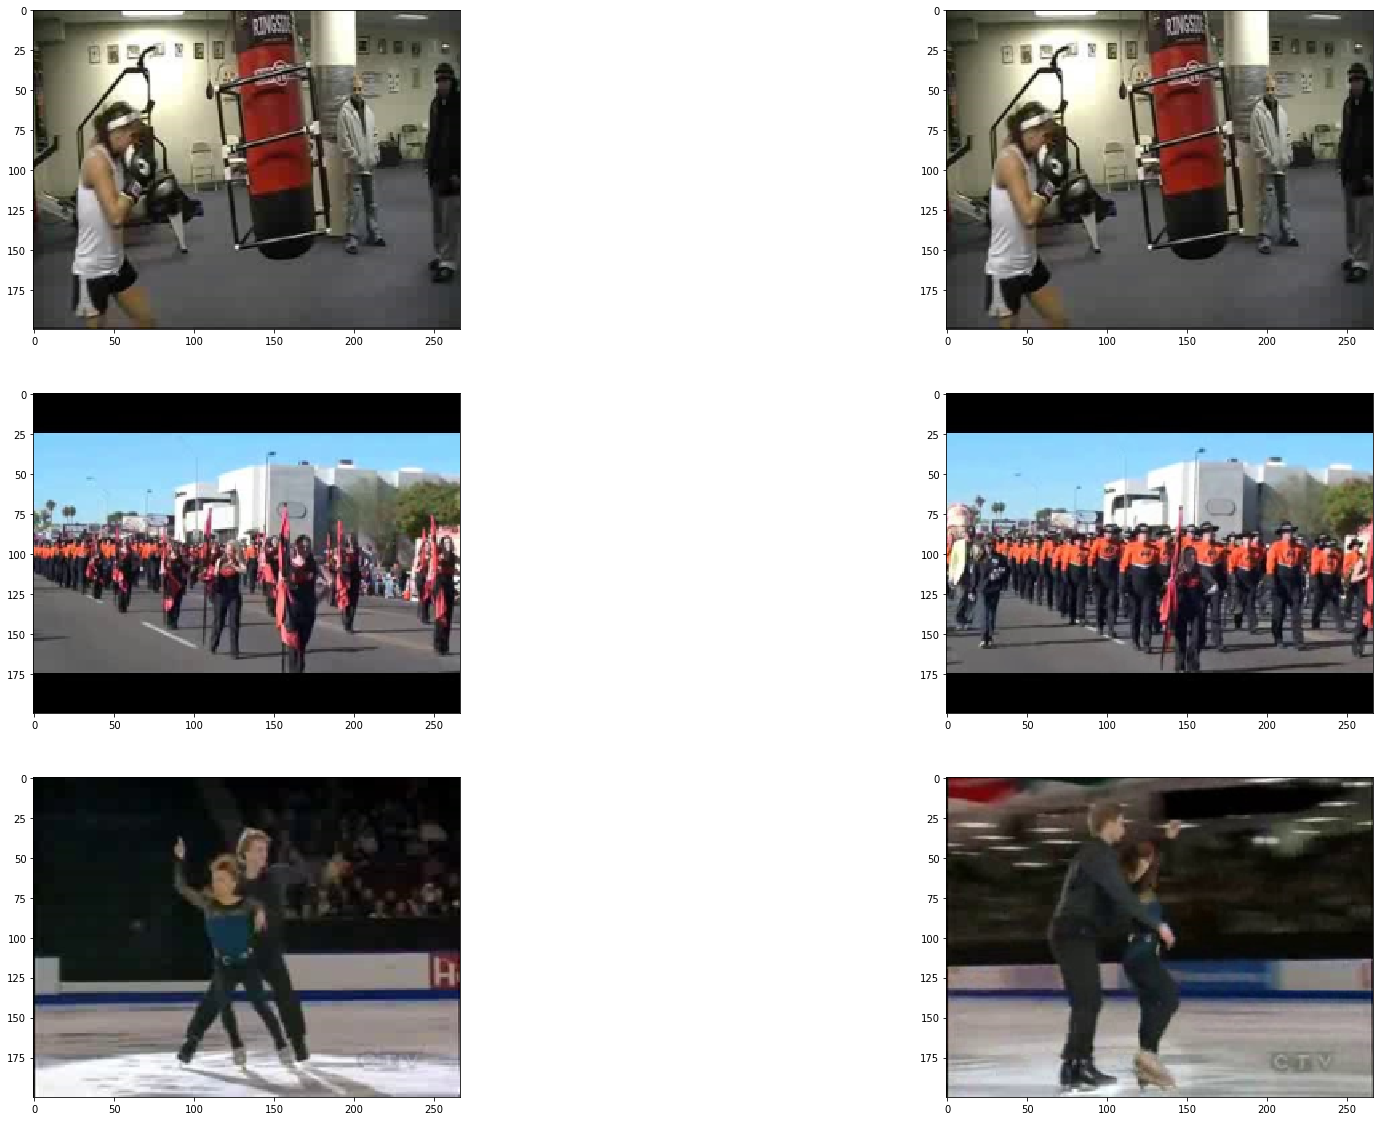

In [9]:
plt.figure(figsize=(30, 20))
plt.subplot(3,2,1),plt.imshow(cv2.cvtColor(input[0][0].transpose(1,2,0), cv2.COLOR_BGR2RGB))
plt.subplot(3,2,2),plt.imshow(cv2.cvtColor(input[0][-1].transpose(1,2,0), cv2.COLOR_BGR2RGB))
plt.subplot(3,2,3),plt.imshow(cv2.cvtColor(input[1][0].transpose(1,2,0), cv2.COLOR_BGR2RGB))
plt.subplot(3,2,4),plt.imshow(cv2.cvtColor(input[1][-1].transpose(1,2,0), cv2.COLOR_BGR2RGB))
plt.subplot(3,2,5),plt.imshow(cv2.cvtColor(input[2][0].transpose(1,2,0), cv2.COLOR_BGR2RGB))
plt.subplot(3,2,6),plt.imshow(cv2.cvtColor(input[2][-1].transpose(1,2,0), cv2.COLOR_BGR2RGB))